In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd.functional import jacobian
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from torchsummary import summary

#Catena di Markov:

*   $\texttt{entropy}$ --> calcola l'entropia di una sequenza
*   $\texttt{make_entropy_MK}$ --> genera una matrice di transizione per una catena di Markov con una certa entropia
*   $\texttt{sample_MK}$ --> genera una catena di Markov sulla base di una matrice di transizione
*   $\texttt{KL_divergence}$ --> divergenza di Kullback-Leibler
*   $\texttt{Gradino_Markov}$ --> funzione che implementa il cambio di regime nella catena di Markov


---



$\textit{nessun problema riscontrato}$

In [2]:
def entropy(distr, norm=False):
    distr = np.array(distr)
    min_bin_value = 1.e-12
    ind = np.where(distr > min_bin_value)[0]
    if norm:
        return (-distr[ind] * np.log(distr[ind])).sum() / np.log(distr.shape[0])
    else:
        return (-distr[ind] * np.log(distr[ind])).sum()

In [3]:
def make_entropy_MK(n_bins, target_entropy, norm = True, power=100, tol=0.0001, factor=0.9, max_iter=1e5):
    A = np.random.random(size=(n_bins, n_bins))

    for k in range(n_bins):
        A[k,:] /= A[k,:].sum()

    it = 0

    while it < max_iter:
        lim_distr = np.linalg.matrix_power(A,power)[0,:]
        entr = entropy(lim_distr, norm=norm)

        if np.abs(entr - target_entropy) < tol:
            return A, lim_distr
        else:
            ind_node = np.random.randint(n_bins)
            ind_bin = np.random.randint(n_bins)
            A1 = A.copy()
            A1[ind_node, ind_bin] *= factor
            A1[ind_node,:] /= A1[ind_node,:].sum()
            lim_distr1 = np.linalg.matrix_power(A1,power)[0,:]
            entr1 = entropy(lim_distr1, norm=norm)
            if np.abs(entr1 - target_entropy) > np.abs(entr - target_entropy):
                A1 = A.copy()
                A1[ind_node, ind_bin] *= 2 - factor
                A1[ind_node,:] /= A1[ind_node,:].sum()
            A = A1
            it += 1

print(make_entropy_MK(5,0.2,norm=True,power=100,tol=0.0001,factor=0.9,max_iter=1e6)[1])
print(entropy(make_entropy_MK(5,0.2,norm=True,power=100,tol=0.0001,factor=0.9,max_iter=1e6)[1],norm=True))

[7.38998986e-02 3.06295356e-04 5.65068161e-03 3.18044358e-03
 9.16962681e-01]
0.19991023049278947


In [4]:
def sample_MK(A, n_samples, init_node=-1):
    n_bins = A.shape[0]
    if init_node == -1:
        init_node = np.random.randint(n_bins)
    samples = []
    prev_sample = init_node
    for k in range(n_samples):
        samples.append(np.random.choice(np.arange(n_bins), p=A[prev_sample,:]))
        prev_sample = samples[-1]
    return np.array(samples)

In [5]:
def KL_divergence(distr1, distr2):
    distr1 = np.array(distr1)
    distr2 = np.array(distr2)
    return (distr1 * np.log2(distr1 / distr2)).sum()

In [16]:
def Gradino_Markov(seq_pars):
  n_bins = seq_pars['n_bins']
  power = seq_pars['power']
  initial_entropy = seq_pars['initial_entropy']
  middle_entropy = seq_pars['middle_entropy']
  Aseq = []
  lim_distr_seq = []

  A0, lim_distr0 = make_entropy_MK(n_bins, initial_entropy)
  At = A0.copy()
  lim_distrt = lim_distr0.copy()
  Aseq.append(A0)
  lim_distr_seq.append(lim_distr0)

  A0, lim_distr0 = make_entropy_MK(n_bins, middle_entropy)
  Aseq.append(A0)
  lim_distr_seq.append(lim_distr0)

  subseqs_len = seq_pars['tot_len']
  transitions_len = seq_pars['transition_len']
  n_subseqs = len(Aseq) # 2, sequenza iniziale e finale

  samples = []
  A_samples = []
  lim_distr_samples = []
  entropy_seq = []
  init_node = -1
  for k in range(n_subseqs):
    samples += list(sample_MK(Aseq[k], subseqs_len, init_node=init_node)) #catena mk lunga subseq_len
    for j in range(subseqs_len):
        A_samples += [Aseq[k]]
        lim_distr_samples += [lim_distr_seq[k]]
        entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]

    #passo in modo graduale da una matrice a un altra tramite tante matrici (50) e ogni volta estraggo uno stato da una di esse
    if k < n_subseqs - 1:
        B = np.zeros((n_bins, n_bins, transitions_len))
        B[:,:,0] = Aseq[k]
        B[:,:,-1] = Aseq[k+1]

        for i in range(n_bins):
            for j in range(n_bins):
                B[i,j,:] = np.linspace(Aseq[k][i][j], Aseq[k+1][i][j], transitions_len)

        for i in range(transitions_len):
            A_samples += [B[:,:,i]]
            samples += [sample_MK(A_samples[-1], 1, init_node=samples[-1])[-1]]
            lim_distr_samples += [np.linalg.matrix_power(A_samples[-1], power)[0,:]]
            entropy_seq += [entropy(lim_distr_samples[-1], norm=False)]

    init_node = samples[-1]

  samples = np.array(samples)
  A_samples = np.array(A_samples)
  lim_distr_samples = np.array(lim_distr_samples)

  ns_seq_dict = dict()
  ns_seq_dict['A'] = A_samples
  ns_seq_dict['seq'] = samples
  ns_seq_dict['distrs_seq'] = lim_distr_samples
  ns_seq_dict['entropy_seq'] = entropy_seq
  return ns_seq_dict

#Rete neurale di Lyapunov applicata ad una catena di Markov

*   $\texttt{class FeedForward}$ --> classe per una semplice rete feed forward
*   ciclo di training per massimizzare l'esponente di Lyapunov


---


$\textit{per alcuni valori del numero di neuroni nei layer della rete il calcolo dello jacobiano fallisce,}$
$\textit{in particolare quando il numero dei neuroni in entrata e uscita è maggiore di quello dell' hidden layer}$


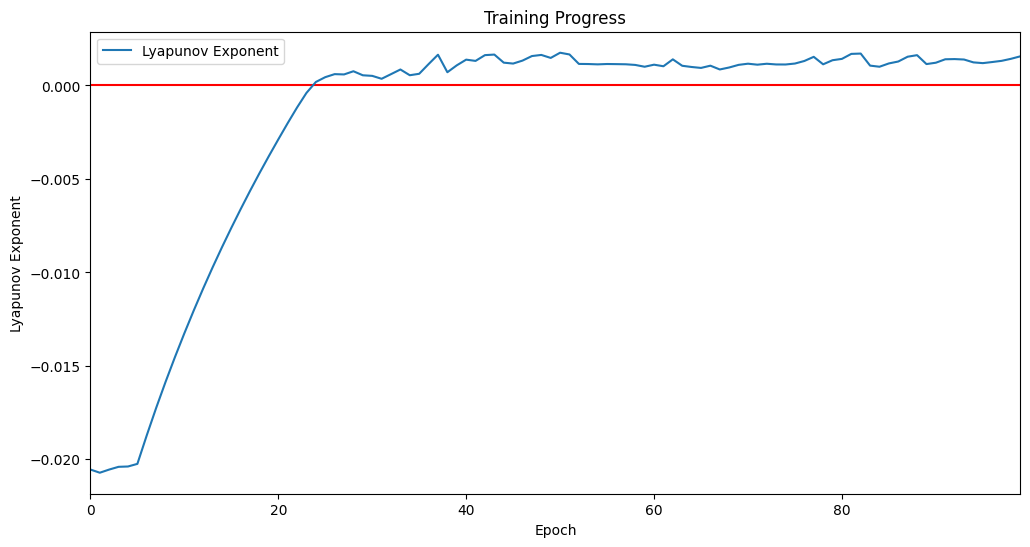

Final Lyapunov Exponent: 0.001557844877243042
Final Eigenvalues sum: tensor(-0.0901, grad_fn=<MeanBackward0>)


In [8]:
# Definition of a neural network

class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.Tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.Tanh(x)
        x = self.fc2(x)

        return x

# Hyperparameters
input_size = 20
hidden_size = 20
output_size = input_size
num_steps = 50
epochs = 100
learning_rate = 0.01
mk = 0
# Model and initial condition
if mk :
  mtx = make_entropy_MK(input_size, 0.3, True, 100, 1e-03,0.9, 1e5)[0]
  chain = sample_MK(mtx, input_size)
  model = FeedForward(input_size, hidden_size, output_size)
  initial_condition = torch.zeros((1, input_size))
  initial_condition[0, :] =  torch.tensor(chain)
else:
  model = FeedForward(input_size, hidden_size, output_size)
  initial_condition = torch.rand((1, input_size))


# Lyapunov exponent plot
lyapunov_exponent_plot = np.zeros(epochs)

# Input trajectory
input_trajectory_list = []
lyapunovs_list_mean = torch.zeros(epochs,input_size)

# Choose optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()

    # Initial condition
    input = initial_condition.clone().requires_grad_(True)

    # Lyapunov exponent lists
    eigenvalues_sum = torch.zeros(num_steps, requires_grad=True)

    eigenvalues_prod = torch.ones(num_steps, requires_grad=True)

    lyapunovs_sum = torch.zeros(num_steps, requires_grad=True)

    lyapunov_max = torch.zeros(num_steps, requires_grad=True)

    lyapunovs_list = torch.zeros(input_size)
    for i in range(num_steps):
        # Compute Jacobian matrix for the original trajectory
        jacobian_matrix = jacobian(model, input, create_graph=True)
        jacobian_matrix = torch.reshape(jacobian_matrix.clone(), (input_size, input_size))

        # Calculate Eigenvalues
        if torch.isnan(jacobian_matrix).any() or torch.isinf(jacobian_matrix).any():
            # Handle NaN or Inf values in the Jacobian matrix
            print("Jacobian matrix contains NaN or Inf values. Skipping update.")
            continue

        eigenvalues = torch.linalg.eigvals(jacobian_matrix)


        # Update the Lyapunov sum
        eigenvalues_sum = torch.cat((eigenvalues_sum, torch.abs(torch.sum(eigenvalues)).view(1)))

        eigenvalues_prod = torch.cat((eigenvalues_prod, torch.prod(torch.abs(eigenvalues)).view(1)))

        lyapunovs = torch.log(torch.abs(eigenvalues))

        lyapunov_max = torch.cat((lyapunov_max, torch.max(lyapunovs).view(1)))

        lyapunovs_sum = torch.cat((lyapunovs_sum, torch.sum(lyapunovs).view(1)))

        lyapunovs_list+=(lyapunovs)/num_steps

        # Save the input vector to the trajectory
        input_trajectory_list.append(input.detach().numpy().squeeze())

        # Update the trajectory
        input = model(input)

    # Averages of eigenvalues and Lyapunov exponents

    eigenvalues_sum_mean = torch.mean(eigenvalues_sum) # Mean over steps of the sum of the eigenvalues of the jacobian

    eigenvalues_prod_mean = torch.mean(eigenvalues_prod) # mean over steps of the product od the eigenvalues of the jacobian

    lyapunov_exponent = torch.mean(lyapunov_max) # Mean over the logarithm of the absolute value of the biggest eigenvalue (in module) of the jacobian (Biggest Lyapunov Exponent)

    lyapunov_sum_mean = torch.mean(lyapunovs_sum) # Mean over the sum of the lyapunov exponents

    lyapunovs_list_mean[epoch]=(lyapunovs_list) # Mean values of the lyapunov exponents for every epoch

    # alpha an beta are the parameters that regulate the loss
    alpha = + 0.0
    beta = + 1.0

    # Define the loss
    loss =  alpha * torch.abs(lyapunov_exponent) + beta * (-lyapunov_sum_mean) / initial_condition.size(1)  # Normalize by the number of dimensions

    # Learning Step
    loss.backward()
    optimizer.step()

        # Store  Lyapunov exponent
    lyapunov_exponent_plot[epoch] = lyapunov_exponent.item() / initial_condition.size(1)


    # plot the Lyapunov exponent over time
    if epoch > 0:
      clear_output(wait=True)
      plt.figure(figsize=(12, 6))
      plt.axhline(y = 0.0, color = 'r', linestyle = '-')  # specifying horizontal line type
      plt.plot(lyapunov_exponent_plot, label='Lyapunov Exponent')
      plt.xlabel('Epoch')
      plt.ylabel('Lyapunov Exponent')
      plt.title('Training Progress')
      plt.legend()
      plt.xlim((0, epoch))
      plt.show()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Lyapunov Loss: {lyapunov_exponent.item()}')
        print(f'\nlyapunov_sum_mean: {lyapunov_sum_mean}')

# Check the final Lyapunov exponent
print("Final Lyapunov Exponent:", lyapunov_exponent_plot[-1])
print("Final Eigenvalues sum:", lyapunov_sum_mean)
# Convert input trajectory list to a numpy array
input_trajectory_array = np.array(input_trajectory_list)

# Fase di training

* $\texttt{class FeedForward1}$ --> semplice rete con un embedding layer iniziale e layer lineari
* $\texttt{class FeedForward2}$ --> rete semplice con layer lineari
* $\texttt{training_loop}$ --> funzione che implementa un ciclo di training
* $\texttt{training_pars}$ --> dizionario che contiene tutti i parametri per li training
* $\texttt{lyapunov_pars}$ --> dizionario che contiene tutti i paramentri per gli esponenti di Lyapunov
* $\texttt{seq_pars}$ --> dizionario che contiene tutti i paramentri per generare le sequenze di training

---

$\textit{il problema più rilevante riguardava il calcolo dello jacobiano: la funzione} \: \texttt{jacobian()} \: \textit{prende come argomenti una funzione e il suo input, restituendo come risultato un tensore che ha le dimensioni dell'output e dell'input della funzione moltiplicate.}$
$\textit{Per esempio, se l'output ha dimensione (10, 10) e l'input (10), il tensore avrà dimensione (10x10x10), e se volessimo avere da jacobian() una matrice quadrata }$
$\textit{che le dimensioni del vettore di input (come effettivamente vogliamo), non ci sarebbe soluzione (apparentemente).} $
$\textit{Ora, in}\:\texttt{FeedForward1}\:\textit{il layer di embedding aggiunge una dimensione all'input, facendoci ricadere nell'esempio di cui sopra.}$
$\textit{Se non ci sono soluzione, l'unica cosa possibile è o combiare al rete(vedi}\:\texttt{FeedForward2}\:\textit{), o tagliare tutte le altre dimensioni che l'embedding layer restituisce in modo da dare un output compatibile}$
$\textit{(ma in questo caso quanto avrebbe senso conservare questo layer se uno poi lo utilizza in maniera "impropria"?)}$


$\textit{Oltre a questo, mettendo la rete con il layer di embedding, lo jabiano viene totalmente nullo, facendo fallire tutto il training.}$

In [9]:
class FeedForward1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FeedForward1, self).__init__()
    self.fc1 = nn.Linear(hidden_size, hidden_size)
    self.act = nn.Tanh()
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.emb = nn.Embedding(input_size, hidden_size)
    self.soft = nn.Softmax(0)

  def forward(self, x):
    x = x.long()         #serve solo per il summary
    x = self.emb(x)
    x = self.act(x)
    x = self.fc1(x)
    x = self.act(x)
    x = self.fc2(x)
    x = x[0, :]
    x = self.soft(x)

    return x

In [10]:
class FeedForward2(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FeedForward2, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.act = nn.Tanh()
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.soft = nn.Softmax(0)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act(x)
    x = self.fc2(x)
    x = self.soft(x)

    return x

In [11]:
model = FeedForward2(10, 100, 10)
summary(model, (1, 10))
model = FeedForward1(10, 100, 10)
summary(model, (1, 10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           1,100
              Tanh-2               [-1, 1, 100]               0
            Linear-3                [-1, 1, 10]           1,010
           Softmax-4                [-1, 1, 10]               0
Total params: 2,110
Trainable params: 2,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1           [-1, 1, 10, 100]           1,000
              Tanh-2           [-1, 1, 10, 100]               0
            Linear-3           [-1, 1, 10, 10

In [19]:
def training_loop(seq, training_pars, lyapunov_pars):

  input_size = training_pars['input_size']
  hidden_size = training_pars['hidden_size']
  output_size = input_size
  lr = training_pars['learning_rate']
  seq_length = input_size
  batch_size = training_pars['batch_size']

  alpha = lyapunov_pars['alpha']
  beta = lyapunov_pars['beta']
  num_steps = lyapunov_pars['num_steps']


  model = FeedForward2(input_size, hidden_size, output_size)
  if training_pars['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  if training_pars['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  if training_pars['loss_func'] == 'CrossEntropy':
    loss_func = torch.nn.CrossEntropyLoss()

  train_loss = []

  for step in range(0, len(seq) - 1, seq_length * batch_size):
    loss = 0.0
    optimizer.zero_grad()

    model.train()
    for b in range(batch_size):
      fr = step + seq_length * b
      to = fr + seq_length + 1
      subseq = seq[fr:to]

      inp = torch.Tensor(subseq[:-1])              #
      target = torch.LongTensor([subseq[-1]])      #la modeifica al ciclo originale dovrebbe essere questa ma è da controllare bene

      out = model(inp)

      #parte sull'esponente di Lyapunov
      input = inp.clone().requires_grad_(True)
      lyapunovs_sum = torch.zeros(num_steps, requires_grad=True)
      lyapunov_max = torch.zeros(num_steps, requires_grad=True)

      for i in range(num_steps):
        jacobian_matrix = jacobian(model, input, create_graph=True)
        jacobian_matrix = torch.reshape(jacobian_matrix.clone(), (input_size, input_size))

        if torch.isnan(jacobian_matrix).any() or torch.isinf(jacobian_matrix).any():
            # Handle NaN or Inf values in the Jacobian matrix
            print("Jacobian matrix contains NaN or Inf values. Skipping update.")
            break

        eigenvalues = torch.linalg.eigvals(jacobian_matrix)
        lyapunovs = torch.log(torch.abs(eigenvalues))
        lyapunov_max = torch.cat((lyapunov_max, torch.max(lyapunovs).view(1)))
        lyapunovs_sum = torch.cat((lyapunovs_sum, torch.sum(lyapunovs).view(1)))

        input = model(input)

      lyapunov_exponent = torch.mean(lyapunov_max)
      lyapunov_sum_mean = torch.mean(lyapunovs_sum)
      #print(lyapunov_exponent)


      loss += loss_func(out.reshape(1, input_size), target) + alpha * torch.abs(lyapunov_exponent) + beta * (-lyapunov_sum_mean) / input.size(0)

    loss /= batch_size
    print(loss)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

In [22]:
training_pars = dict()
training_pars['input_size'] = 10
training_pars['hidden_size'] = 10
training_pars['optimizer'] = 'adam'
training_pars['learning_rate'] = 0.0005
training_pars['loss_func'] = 'CrossEntropy'
training_pars['batch_size'] = 3

lyapunov_pars = dict()
lyapunov_pars['num_steps'] = 50
lyapunov_pars['alpha'] = 0.0
lyapunov_pars['beta'] = 0.01

seq_pars = dict()
seq_pars['power'] = 20
seq_pars['n_bins'] = 10                  # deve essere uguale all'input size
seq_pars['initial_entropy'] = 0.2
seq_pars['middle_entropy'] = 0.3
seq_pars['tot_len'] = 5000
seq_pars['transition_len'] = 50

ns_seq_dict = Gradino_Markov(seq_pars)

In [23]:
training_loop(ns_seq_dict['seq'], training_pars, lyapunov_pars)

tensor(2.3850, grad_fn=<DivBackward0>)
tensor(2.3832, grad_fn=<DivBackward0>)
tensor(2.3836, grad_fn=<DivBackward0>)
tensor(2.3834, grad_fn=<DivBackward0>)
tensor(2.3791, grad_fn=<DivBackward0>)
tensor(2.3664, grad_fn=<DivBackward0>)
tensor(2.3813, grad_fn=<DivBackward0>)
tensor(2.3755, grad_fn=<DivBackward0>)
tensor(2.3767, grad_fn=<DivBackward0>)
tensor(2.3783, grad_fn=<DivBackward0>)
tensor(2.3759, grad_fn=<DivBackward0>)
tensor(2.3639, grad_fn=<DivBackward0>)
tensor(2.3513, grad_fn=<DivBackward0>)
tensor(2.3631, grad_fn=<DivBackward0>)
tensor(2.3466, grad_fn=<DivBackward0>)
tensor(2.3517, grad_fn=<DivBackward0>)
tensor(2.3723, grad_fn=<DivBackward0>)
tensor(2.3701, grad_fn=<DivBackward0>)
tensor(2.3703, grad_fn=<DivBackward0>)
tensor(2.3696, grad_fn=<DivBackward0>)
tensor(2.3564, grad_fn=<DivBackward0>)
tensor(2.3587, grad_fn=<DivBackward0>)
tensor(2.3560, grad_fn=<DivBackward0>)
tensor(2.3567, grad_fn=<DivBackward0>)
tensor(2.3567, grad_fn=<DivBackward0>)
tensor(2.3656, grad_fn=<D

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x9 and 10x10)